In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv("data/train.csv")
data.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [3]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

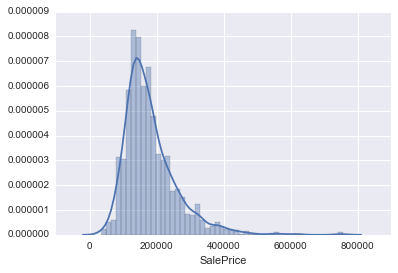

In [4]:
sns.distplot(data['SalePrice'])

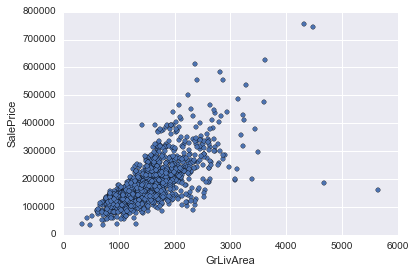

In [5]:
var = 'GrLivArea'
tmp = pd.concat([data['SalePrice'],data[var]], axis=1)
tmp.plot.scatter(x = var, y = 'SalePrice', ylim=(0,800000))

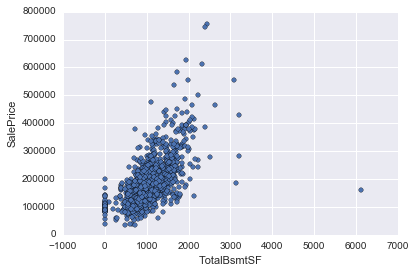

In [6]:
var = 'TotalBsmtSF'
tmp = pd.concat([data['SalePrice'],data[var]], axis=1)
tmp.plot.scatter(x = var, y = 'SalePrice', ylim=(0,800000))

可以看出saleprice 和 'GrLivArea' ，'TotalBsmtSF'存在线性关系，且是正相关。

(-0.5, 9.5, 0, 800000)

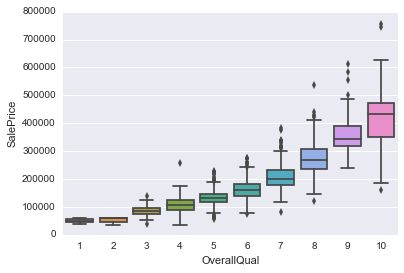

In [7]:
#box plot
var = 'OverallQual'
tmp_data = pd.concat([data['SalePrice'], data[var]], axis=1)
fig = sns.boxplot(x = var, y = "SalePrice", data = tmp_data)
fig.axis(ymin = 0, ymax = 800000)

可以看出saleprice 和 'OverallQual'存在线性关系。

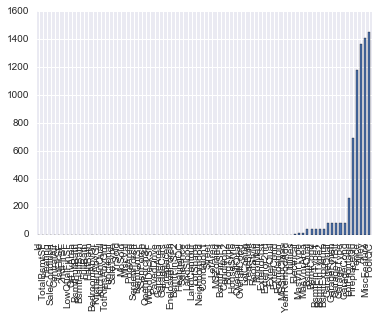

In [8]:
#查看一下缺失值
missing = data.isnull().sum()
missing.sort_values(inplace=True)
missing.plot.bar()

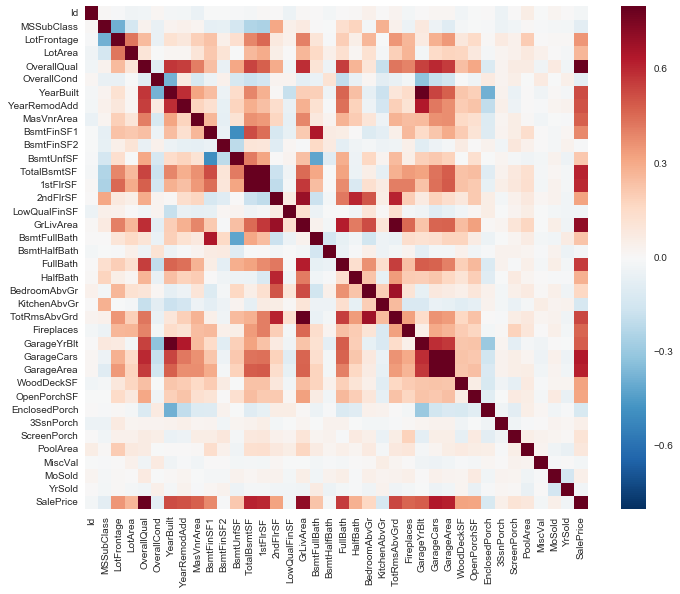

In [9]:
#相关矩阵
corrmat = data.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax = .8, square = True)

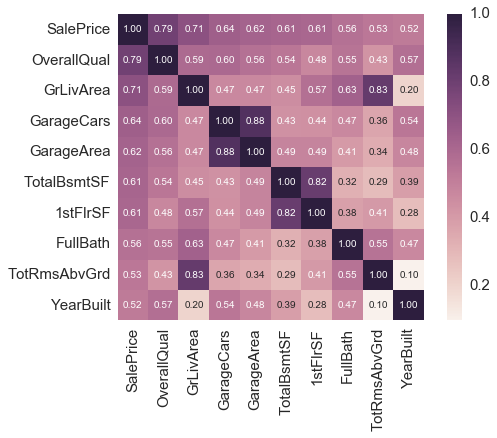

In [10]:
#zoomed heatmap
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

可以看出变量之间的相关性：

- 'OverallQual', 'GrLivArea' and ‘TotalBsmtSF’：相关性很大
- 'GarageCars' and 'GarageArea' ：相关性也大，但是这两个变量间存在信心冗余，因为停车间能停多少辆车完全是由停车房的面积决定的，所以可以就选择一个变量。选择’GarageCars’，相关性更大一些。
- ‘YearBuilt’似乎也具有一定的相关性，但是分析这个就应该做分析时间序列分析。

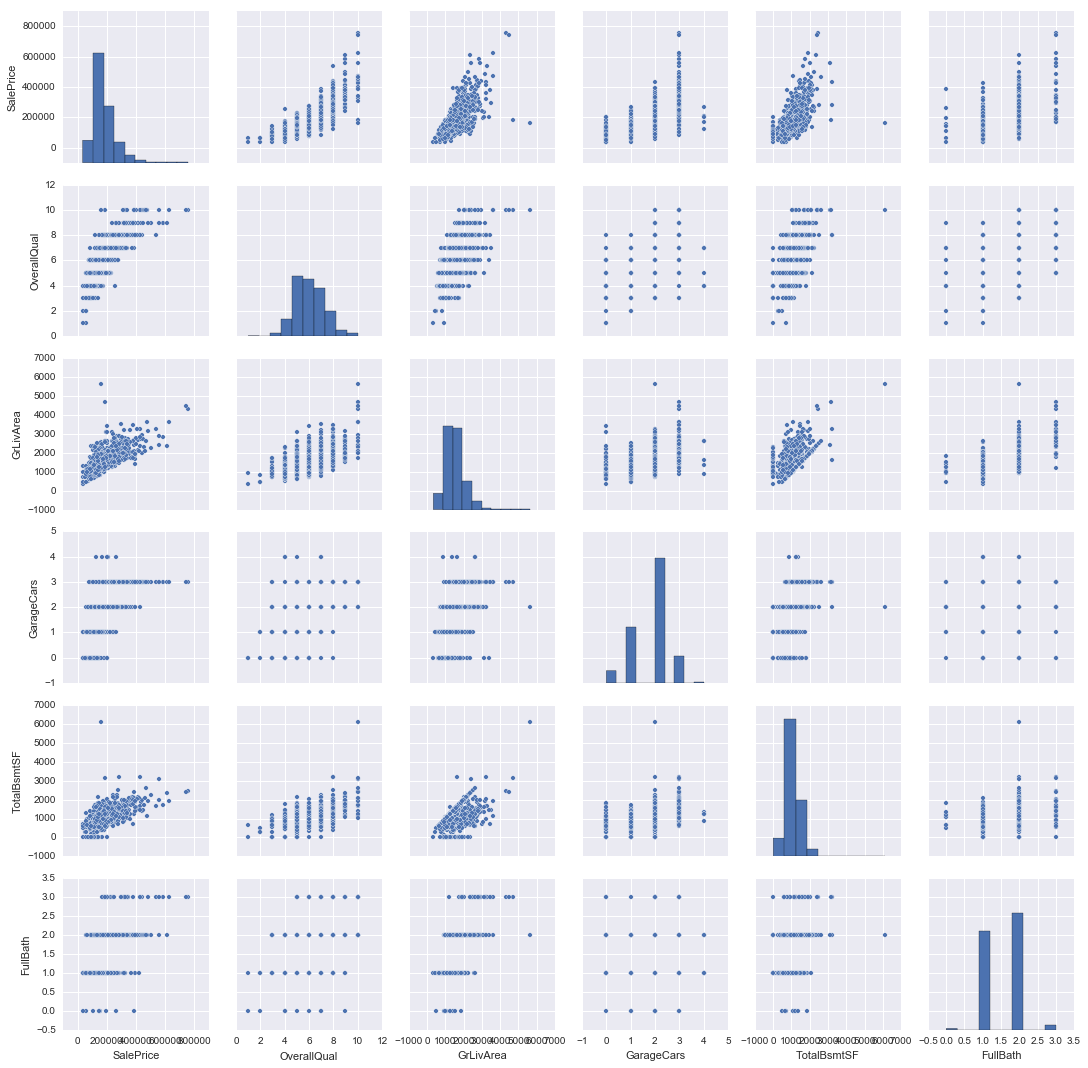

In [11]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
sns.pairplot(data[cols], size = 2.5)
plt.show()

In [12]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [13]:
#处理缺失值
data = data.drop((missing_data[missing_data['Total'] > 1]).index, 1) #Note: axis=1 denotes that we are referring to a column, not a row
data = data.drop(data.loc[data['Electrical'].isnull()].index)
data.isnull().sum().max() #检查异常值是否处理完毕

0

In [21]:
#处理缺失值
saleprice_scaled = StandardScaler().fit_transform(data['SalePrice'][:,np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]
print('outer range(low) of the distribution:')
print(low_range)
print('\nouter range(high) of the distribution')
print(high_range)

outer range(low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range(high) of the distribution
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


进行正态化后，可以看出：

低范围的值都比较相似并且在0附近分布。
高范围的值离0很远，并且七点几的值远在正常范围之外。


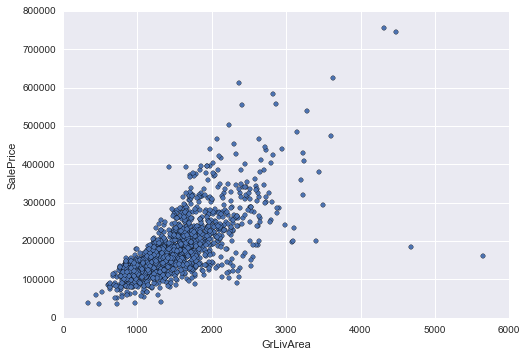

In [24]:
#双变量分析
#1. ‘GrLivArea’和’SalePrice’双变量分析
var = 'GrLivArea'
tmp_data = pd.concat([data['SalePrice'], data[var]], axis = 1)
tmp_data.plot.scatter(x = var, y = 'SalePrice', ylim=(0,800000))

从图中可以看出，右下有两个明显离群的点，不符合近于线性增长的趋势。或许是代表了农业地区，价格很低，但是不能代表典型案例，所以将它们视为异常值删除。


In [26]:
#删除异常值
data.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [27]:
data = data.drop(data[data['Id'] == 1299].index)
data = data.drop(data[data['Id'] == 524].index)

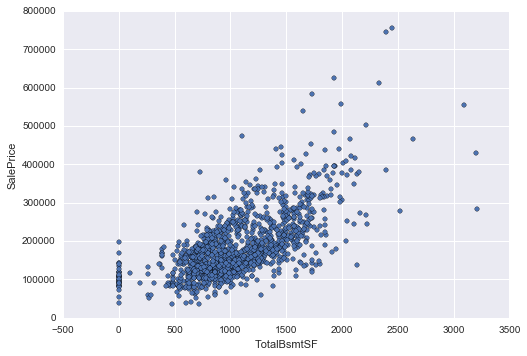

In [29]:
#2. ‘TotalBsmtSF’和’SalePrice’双变量分析
var = 'TotalBsmtSF'
tmp_data = pd.concat([data['SalePrice'], data[var]], axis = 1)
tmp_data.plot.scatter(x = var, y = 'SalePrice', ylim = (0,800000))